# Demo - Tabular Dataset

In [ ]:
import sys, os
from pyprojroot import here

# # spyder up to find the root
# exp_root = here(project_files=[".exp_root"])
code_root = here(project_files=[".here"])

# # append to path
# sys.path.append(str(exp_root))
sys.path.append(str(code_root))

In [10]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import corner
from survae.datasets.tabular import GasDataModule, MiniBooNEDataModule, BSDS300DataModule, HEPMASSDataModule, PowerDataModule

%load_ext autoreload
%autoreload 2

FileNotFoundError: [Errno 2] No such file or directory

## Data

In [3]:
dm = PowerDataModule()

In [4]:
dm.prepare_data()

In [5]:
dm.setup()

In [6]:
dm.data_train.shape, dm.data_val.shape, dm.data_test.shape

((1659917, 6), (184435, 6), (204928, 6))

In [7]:
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()
valid_loader = dm.val_dataloader()

In [8]:
init_X = dm.data_train[:10_000]

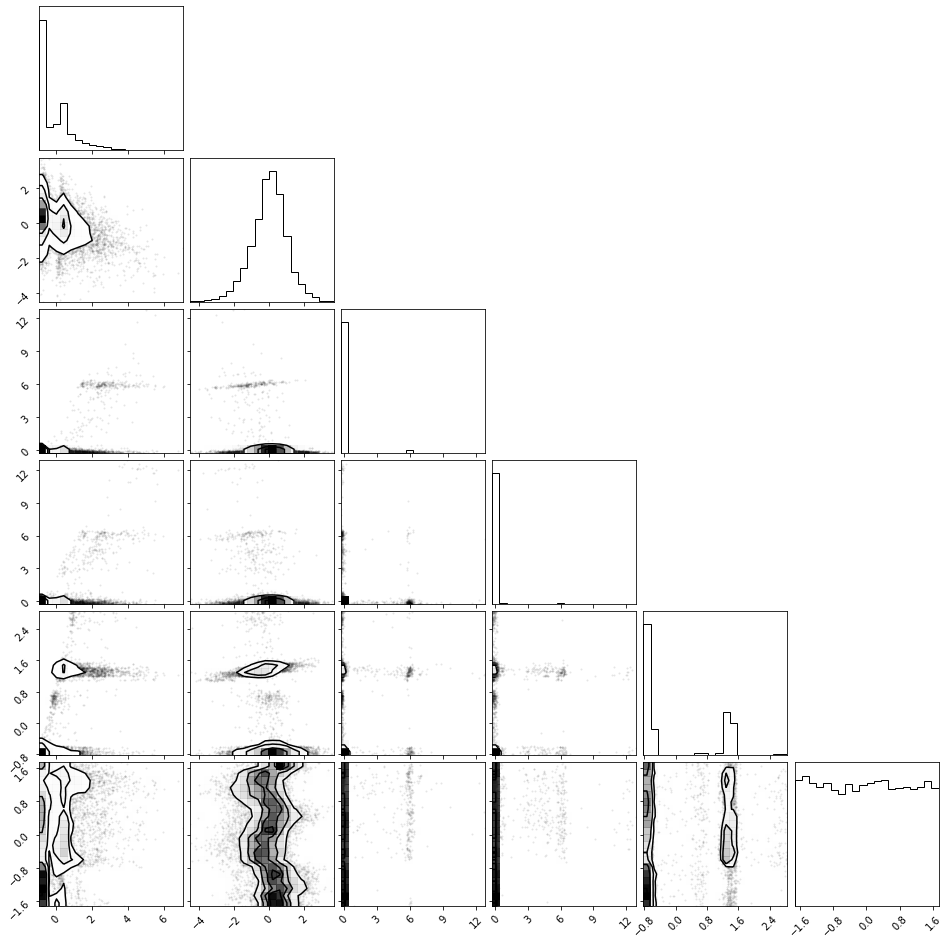

In [9]:
import corner

fig = corner.corner(init_X[:, :10])

## Model

In [12]:
from survae.distributions import StandardNormal
from survae.flows import Flow
from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, InverseGaussCDF
from survae.transforms.bijections.linear_orthogonal import FastHouseholder

In [13]:
# GF (Logistic Kernel CDF)
num_mixtures = 8
num_features = 6
num_reflections = 2



model = Flow(base_dist=StandardNormal((num_features,)),
             transforms=[
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
    GaussianMixtureCDF((num_features,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(num_features, num_reflections),
             ])

In [14]:
z, ldj = model.forward_transform(torch.Tensor(init_X))

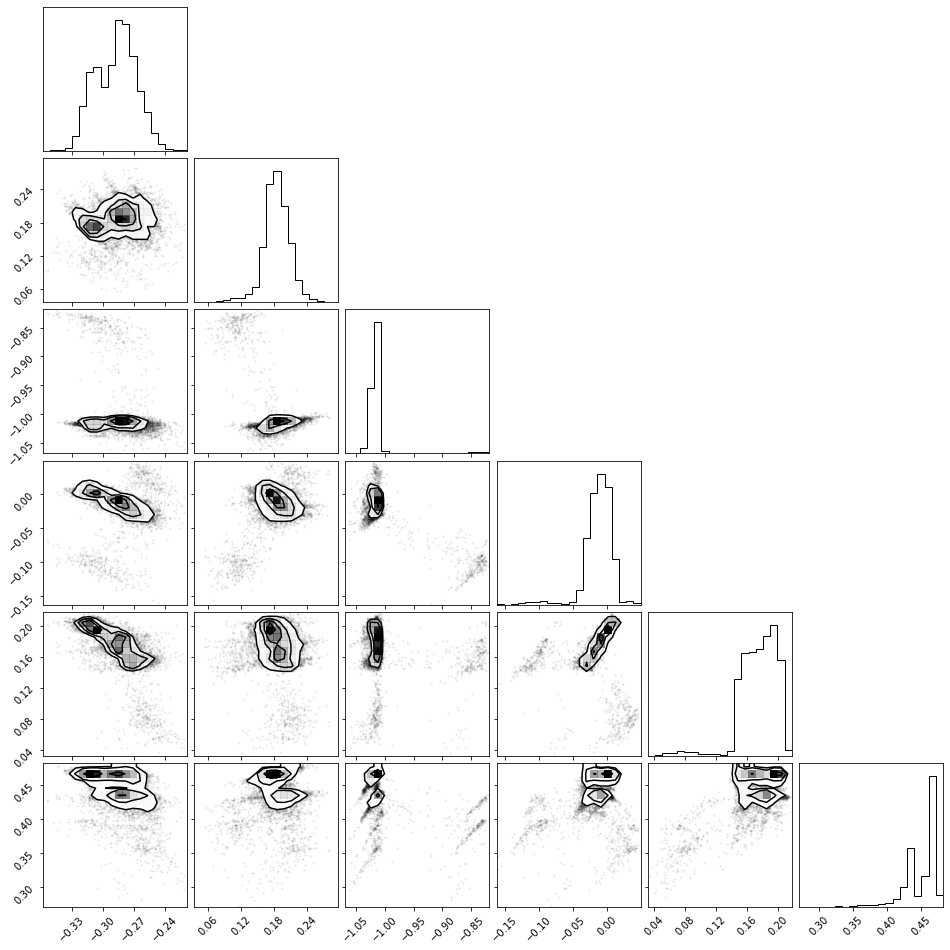

In [15]:

fig = corner.corner(z.detach().numpy())

## Trainer

In [16]:
class Learner2DPlane(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        return {'val_loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)


In [17]:
# initialize trainer
learn = Learner2DPlane(model)

In [19]:
n_epochs = 100

# initialize trainer
trainer = pl.Trainer(min_epochs=1, max_epochs=n_epochs, gpus=1)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [20]:

trainer.fit(learn, dm)

/media/disk/users/emmanuel/.conda/envs/torch_gpu_py39/lib/python3.9/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))
/media/disk/users/emmanuel/.conda/envs/torch_gpu_py39/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type | Params
-------------------------------
0 | model | Flow | 1.9 K 
-------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## Latent Space

In [33]:
z_latent, ldj = model.forward_transform(torch.Tensor(init_X))

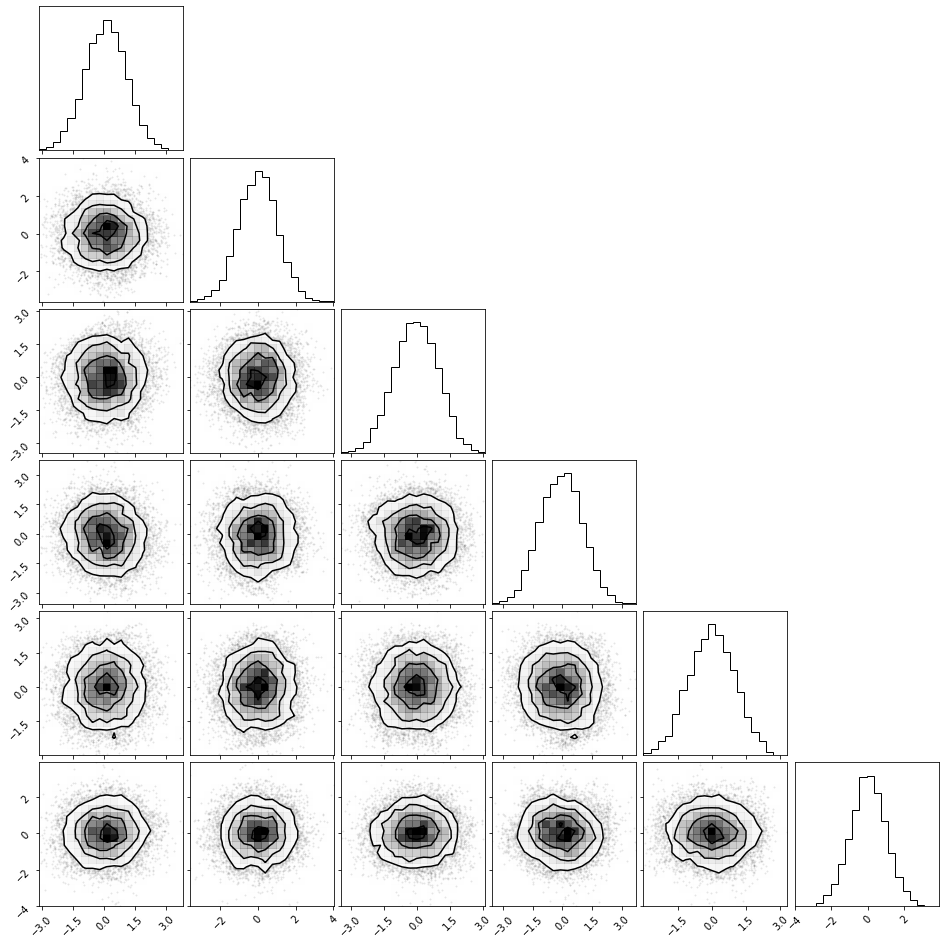

In [34]:
fig = corner.corner(z_latent.detach().numpy())

## Sampling

In [35]:
%%time
print('Sampling...')

samples = model.sample(10_000).detach().numpy()

Sampling...
CPU times: user 1min 21s, sys: 551 ms, total: 1min 22s
Wall time: 4.13 s


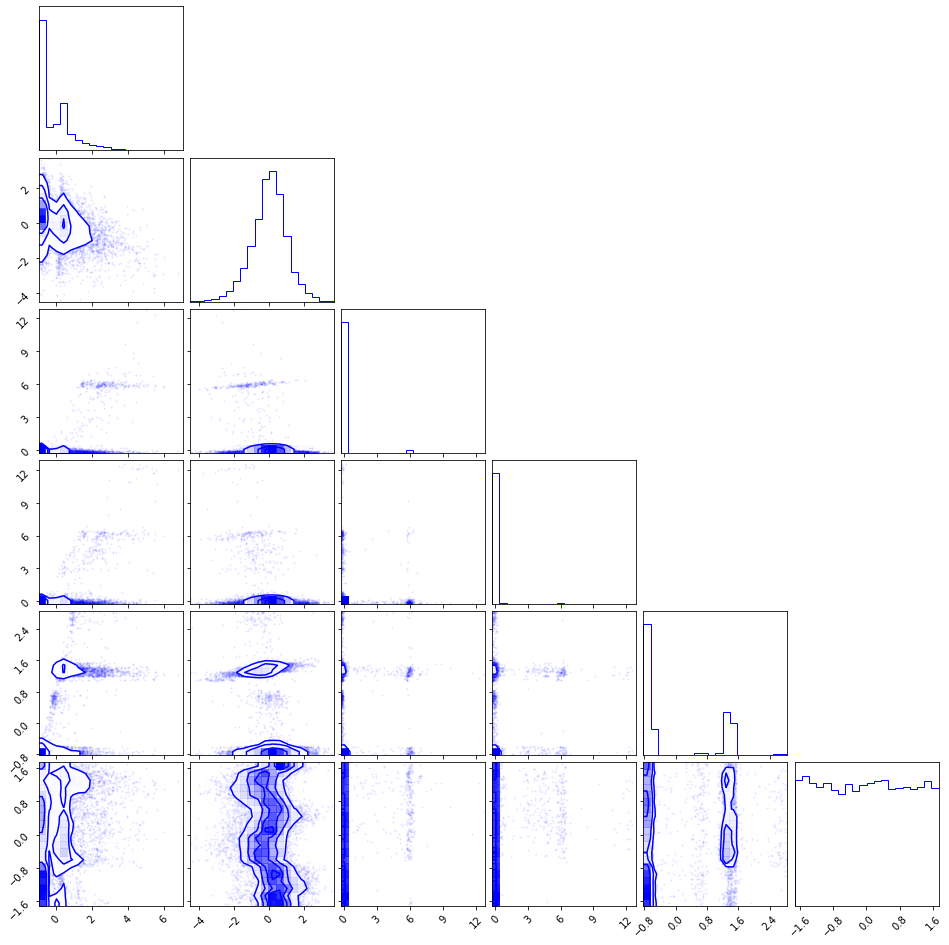

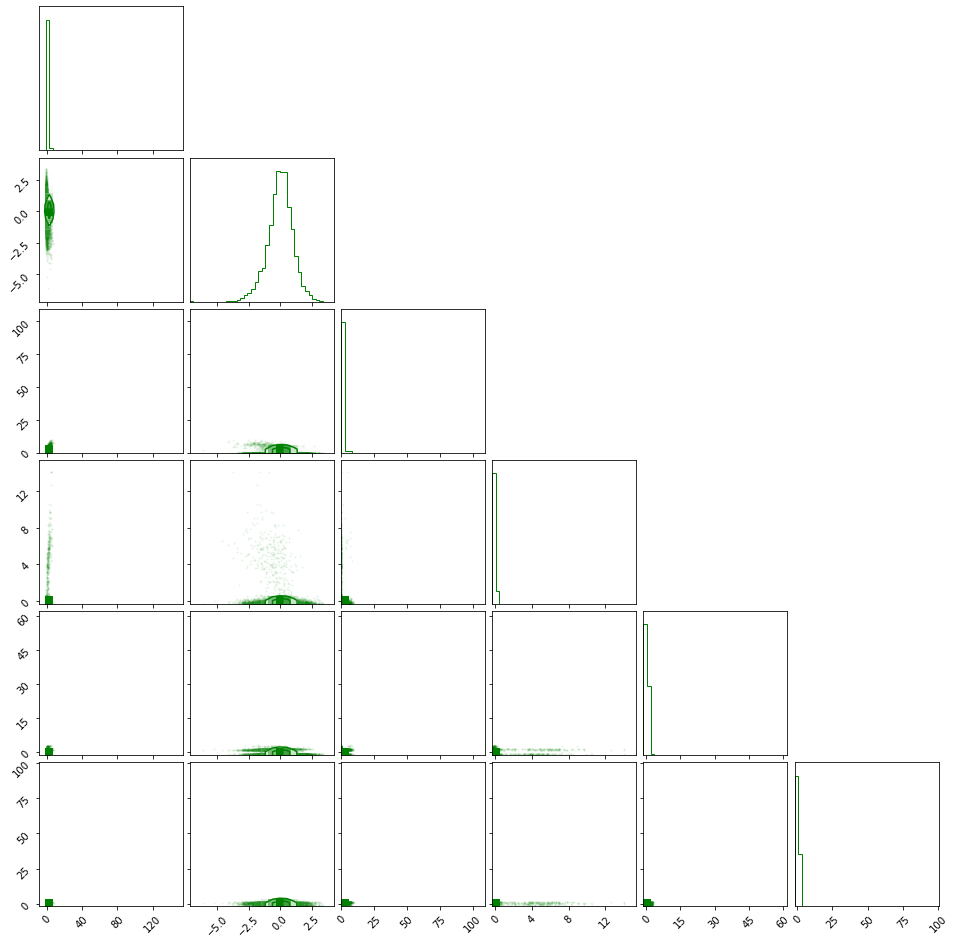

In [36]:
# data = torch.Tensor(init_X).detach().numpy()

fig = corner.corner(init_X, color="blue")


fig = corner.corner(samples, color="green", hist_bin_factor=2, )